### **Author** : Lina Farchado

# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.

Install monai

In [ ]:
pip install 'monai[all]'

Check the installation by running the following cell

In [2]:
import monai
monai.config.print_config()

/opt/conda/lib/python3.10/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.19.0
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 5.9.3
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.19.0
pynrrd version: 1.1.1
clearml version: 1.17.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

In [5]:
import os
from glob import glob
from sklearn.model_selection import train_test_split

data_dir = '/kaggle/input/tnbc-nuclei-segmentation-original-dataset/TNBC_NucleiSegmentation'

image_files = []
label_files = []

for slide_folder in sorted(glob(os.path.join(data_dir, "Slide_*"))):
    slide_number = os.path.basename(slide_folder).split('_')[1]
    
    corresponding_gt_folder = os.path.join(data_dir, f"GT_{slide_number}")
    
    slide_images = sorted(glob(os.path.join(slide_folder, "*.png")))
    gt_images = sorted(glob(os.path.join(corresponding_gt_folder, "*.png")))
    
    image_files.extend(slide_images)
    label_files.extend(gt_images)

train_image_files, test_image_files, train_label_files, test_label_files = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42
)

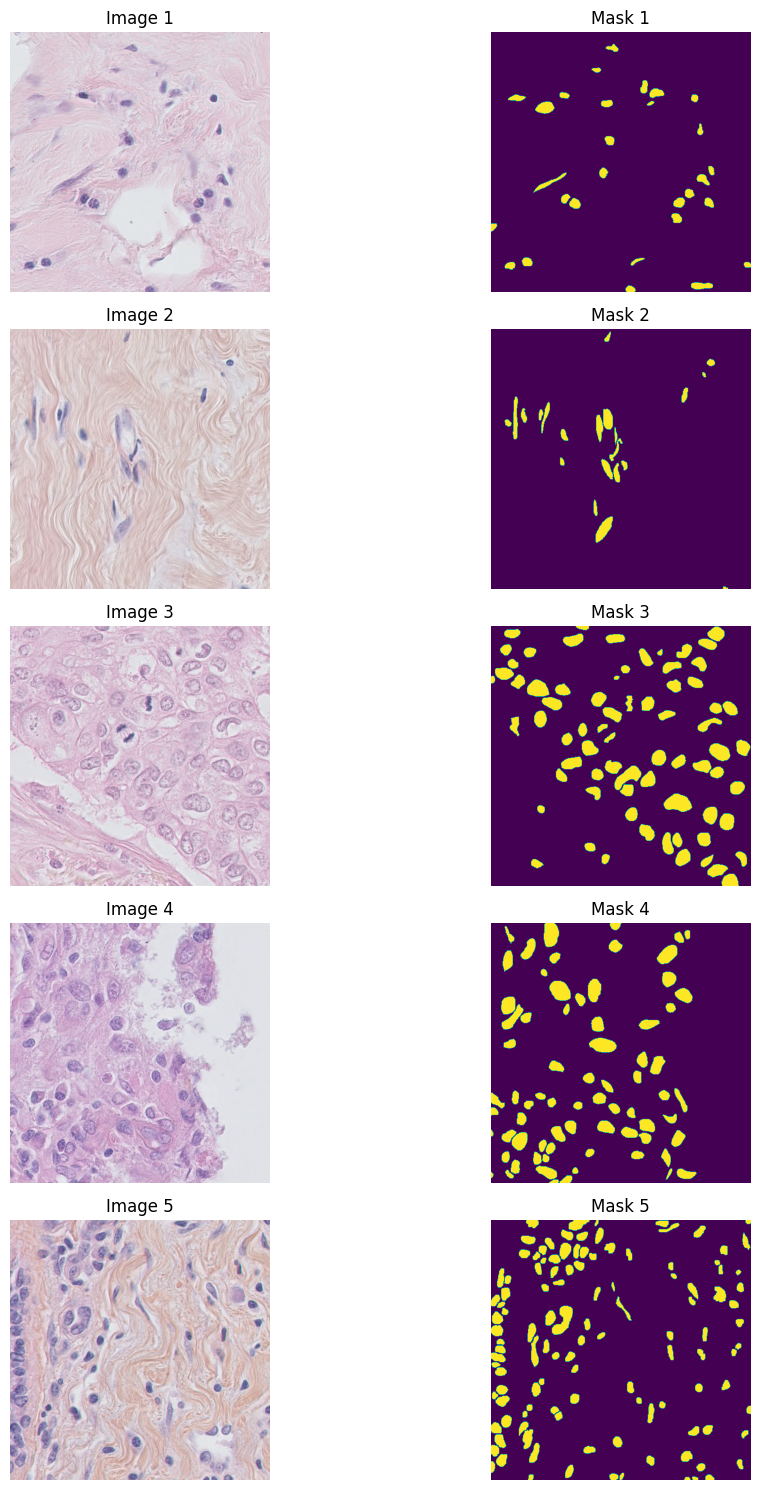

In [6]:
num_images = 5

plt.figure(figsize=(12, num_images * 3))

for i in range(num_images):
    img = mpimg.imread(train_image_files[i])
    mask = mpimg.imread(train_label_files[i])

    # Image
    plt.subplot(num_images, 2, i * 2 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i + 1}')

    # Label
    plt.subplot(num_images, 2, i * 2 + 2)
    plt.imshow(mask)
    plt.axis('off')
    plt.title(f'Mask {i + 1}')

plt.tight_layout()
plt.show()

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.

In [7]:
import torch

from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ToTensor, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader = PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.



In [8]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(label_files[index])


By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [9]:
from torch.utils.data import random_split

val_size = int(0.2 * len(train_image_files))
train_size = len(train_image_files) - val_size

train_dataset, val_dataset = random_split(
    CellDataset(train_image_files, train_label_files, image_trans, label_trans),
    [train_size, val_size]
)

test_dataset = CellDataset(test_image_files, test_label_files, image_trans, label_trans)

## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [11]:
import monai
im, seg = monai.utils.misc.first(train_loader)
print(f'Image Shape: {im.shape}, Label Shape: {seg.shape}')

Image Shape: torch.Size([8, 3, 512, 512]), Label Shape: torch.Size([8, 1, 512, 512])


# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
from monai.networks.nets import UNet

model_UNet = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(24, 48, 96, 192, 384),
    strides=(2, 2, 2, 2),
    dropout=0.2,
).to(device)

# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.



In [14]:
import torch
from monai.losses import DiceLoss

loss_function = DiceLoss(sigmoid=True)

With torch.optim, define an optimizer for your model. Use the Adam optimiser


In [15]:
model_UNet = model_UNet.to(device)
optimizer_UNet = torch.optim.Adam(model_UNet.parameters(), lr=1e-4)

# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training

In [16]:
def train_one_epoch(model, optimizer):
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")

    epoch_loss /= len(train_loader)
    return epoch_loss


def validate(model):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
            val_predictions = model(val_inputs)
            val_loss += loss_function(val_predictions, val_labels).item()

    val_loss /= len(val_loader)
    return val_loss


def train_model_with_validation(model, num_epochs, optimizer, patience=10):
    epoch_loss_values = list()
    val_loss_values = []
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training
        train_loss = train_one_epoch(model, optimizer)
        epoch_loss_values.append(train_loss)
        print(f"Training loss: {train_loss:.4f}")

        # Validation
        val_loss = validate(model)
        val_loss_values.append(val_loss)
        print(f"Validation loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            patience_counter = 0
            print(f"Validation decreased from {best_val_loss} to {val_loss}")
            best_val_loss = val_loss
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            print(f"EarlyStopping counter: {patience_counter} out of {patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered. Best validation loss: {best_val_loss:.4f}")
            break

    model.load_state_dict(best_model_state)
    return model, epoch_loss_values, val_loss_values


In [17]:
model_UNet, epoch_loss_values_UNet, val_loss_values_UNet = train_model_with_validation(model_UNet, 60, optimizer_UNet)

Epoch 1/60
1/4, train_loss: 0.8297
2/4, train_loss: 0.8637
3/4, train_loss: 0.8065
4/4, train_loss: 0.7739
Training loss: 0.8184
Validation loss: 0.7611
Validation decreased from inf to 0.7611019015312195
Epoch 2/60
1/4, train_loss: 0.8013
2/4, train_loss: 0.8201
3/4, train_loss: 0.8354
4/4, train_loss: 0.8154
Training loss: 0.8181
Validation loss: 0.7604
Validation decreased from 0.7611019015312195 to 0.7604475021362305
Epoch 3/60
1/4, train_loss: 0.8227
2/4, train_loss: 0.8785
3/4, train_loss: 0.7605
4/4, train_loss: 0.8086
Training loss: 0.8176
Validation loss: 0.7598
Validation decreased from 0.7604475021362305 to 0.75982666015625
Epoch 4/60
1/4, train_loss: 0.7843
2/4, train_loss: 0.8536
3/4, train_loss: 0.8429
4/4, train_loss: 0.7880
Training loss: 0.8172
Validation loss: 0.7592
Validation decreased from 0.75982666015625 to 0.7592387795448303
Epoch 5/60
1/4, train_loss: 0.8456
2/4, train_loss: 0.8227
3/4, train_loss: 0.7828
4/4, train_loss: 0.8160
Training loss: 0.8168
Validation

Display the prediction of your model on several image

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from monai.metrics import DiceMetric, HausdorffDistanceMetric

def visualize_predictions(model, num_images=5):
    model.eval()
    plt.figure(figsize=(15, 5 * num_images))
    
    image_count = 0
    
    with torch.no_grad():
        for batch_data in test_loader:
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            predictions = model(inputs)
            predictions = torch.sigmoid(predictions) > 0.5
            
            batch_size = inputs.shape[0]
            for j in range(batch_size):
                if image_count >= num_images:
                    break
                
                plt.subplot(num_images, 3, image_count * 3 + 1)
                plt.imshow(inputs[j].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
                plt.title(f'Original Image {image_count + 1}')
                plt.axis('off')

                plt.subplot(num_images, 3, image_count * 3 + 2)
                plt.imshow(labels[j].cpu().squeeze(), cmap='gray')
                plt.title(f'Ground Truth {image_count + 1}')
                plt.axis('off')

                plt.subplot(num_images, 3, image_count * 3 + 3)
                plt.imshow(predictions[j].cpu().squeeze(), cmap='gray')
                plt.title(f'Prediction {image_count + 1}')
                plt.axis('off')

                image_count += 1
            if image_count >= num_images:
                break
    
    plt.tight_layout()
    plt.show()

def calculate_metrics(model):
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    hausdorff_metric = HausdorffDistanceMetric(include_background=True, percentile=95)
    
    model.eval()
    with torch.no_grad():
        for batch_data in test_loader:
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            predictions = model(inputs)
            predictions = torch.sigmoid(predictions) > 0.5
            
            dice_metric(y_pred=predictions, y=labels)
            hausdorff_metric(y_pred=predictions, y=labels)
    
    dice_scores = dice_metric.aggregate()
    hausdorff_distances = hausdorff_metric.aggregate()
    
    return {
        'Mean Dice Score': dice_scores.mean().item(),
        'Mean Hausdorff Distance': hausdorff_distances.mean().item()
    }

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model

In [19]:
from monai.networks.nets import DynUNet

In [20]:
model_dyn_UNet = DynUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    kernel_size=[[3, 3], [3, 3], [3, 3], [3, 3]],
    strides=[[1, 1], [2, 2], [2, 2], [2, 2]],
    upsample_kernel_size=[[2, 2], [2, 2], [2, 2]]
)

In [21]:
model_dyn_UNet = model_dyn_UNet.to(device)
optimizer_model_dyn_UNet = torch.optim.Adam(model_dyn_UNet.parameters(), lr=1e-4)

In [22]:
model_dyn_UNet, epoch_loss_values_dyn_UNet, val_loss_values_dyn_UNet = train_model_with_validation(model_dyn_UNet, 60, optimizer_model_dyn_UNet)

Epoch 1/60
1/4, train_loss: 0.8627
2/4, train_loss: 0.7700
3/4, train_loss: 0.8521
4/4, train_loss: 0.7869
Training loss: 0.8179
Validation loss: 0.7600
Validation decreased from inf to 0.7599713802337646
Epoch 2/60
1/4, train_loss: 0.8401
2/4, train_loss: 0.8139
3/4, train_loss: 0.8523
4/4, train_loss: 0.7574
Training loss: 0.8159
Validation loss: 0.7593
Validation decreased from 0.7599713802337646 to 0.7593246698379517
Epoch 3/60
1/4, train_loss: 0.7672
2/4, train_loss: 0.8705
3/4, train_loss: 0.7895
4/4, train_loss: 0.8307
Training loss: 0.8145
Validation loss: 0.7588
Validation decreased from 0.7593246698379517 to 0.7587646245956421
Epoch 4/60
1/4, train_loss: 0.7710
2/4, train_loss: 0.8183
3/4, train_loss: 0.8492
4/4, train_loss: 0.8137
Training loss: 0.8131
Validation loss: 0.7584
Validation decreased from 0.7587646245956421 to 0.7584024667739868
Epoch 5/60
1/4, train_loss: 0.7699
2/4, train_loss: 0.8347
3/4, train_loss: 0.8382
4/4, train_loss: 0.8033
Training loss: 0.8115
Valida

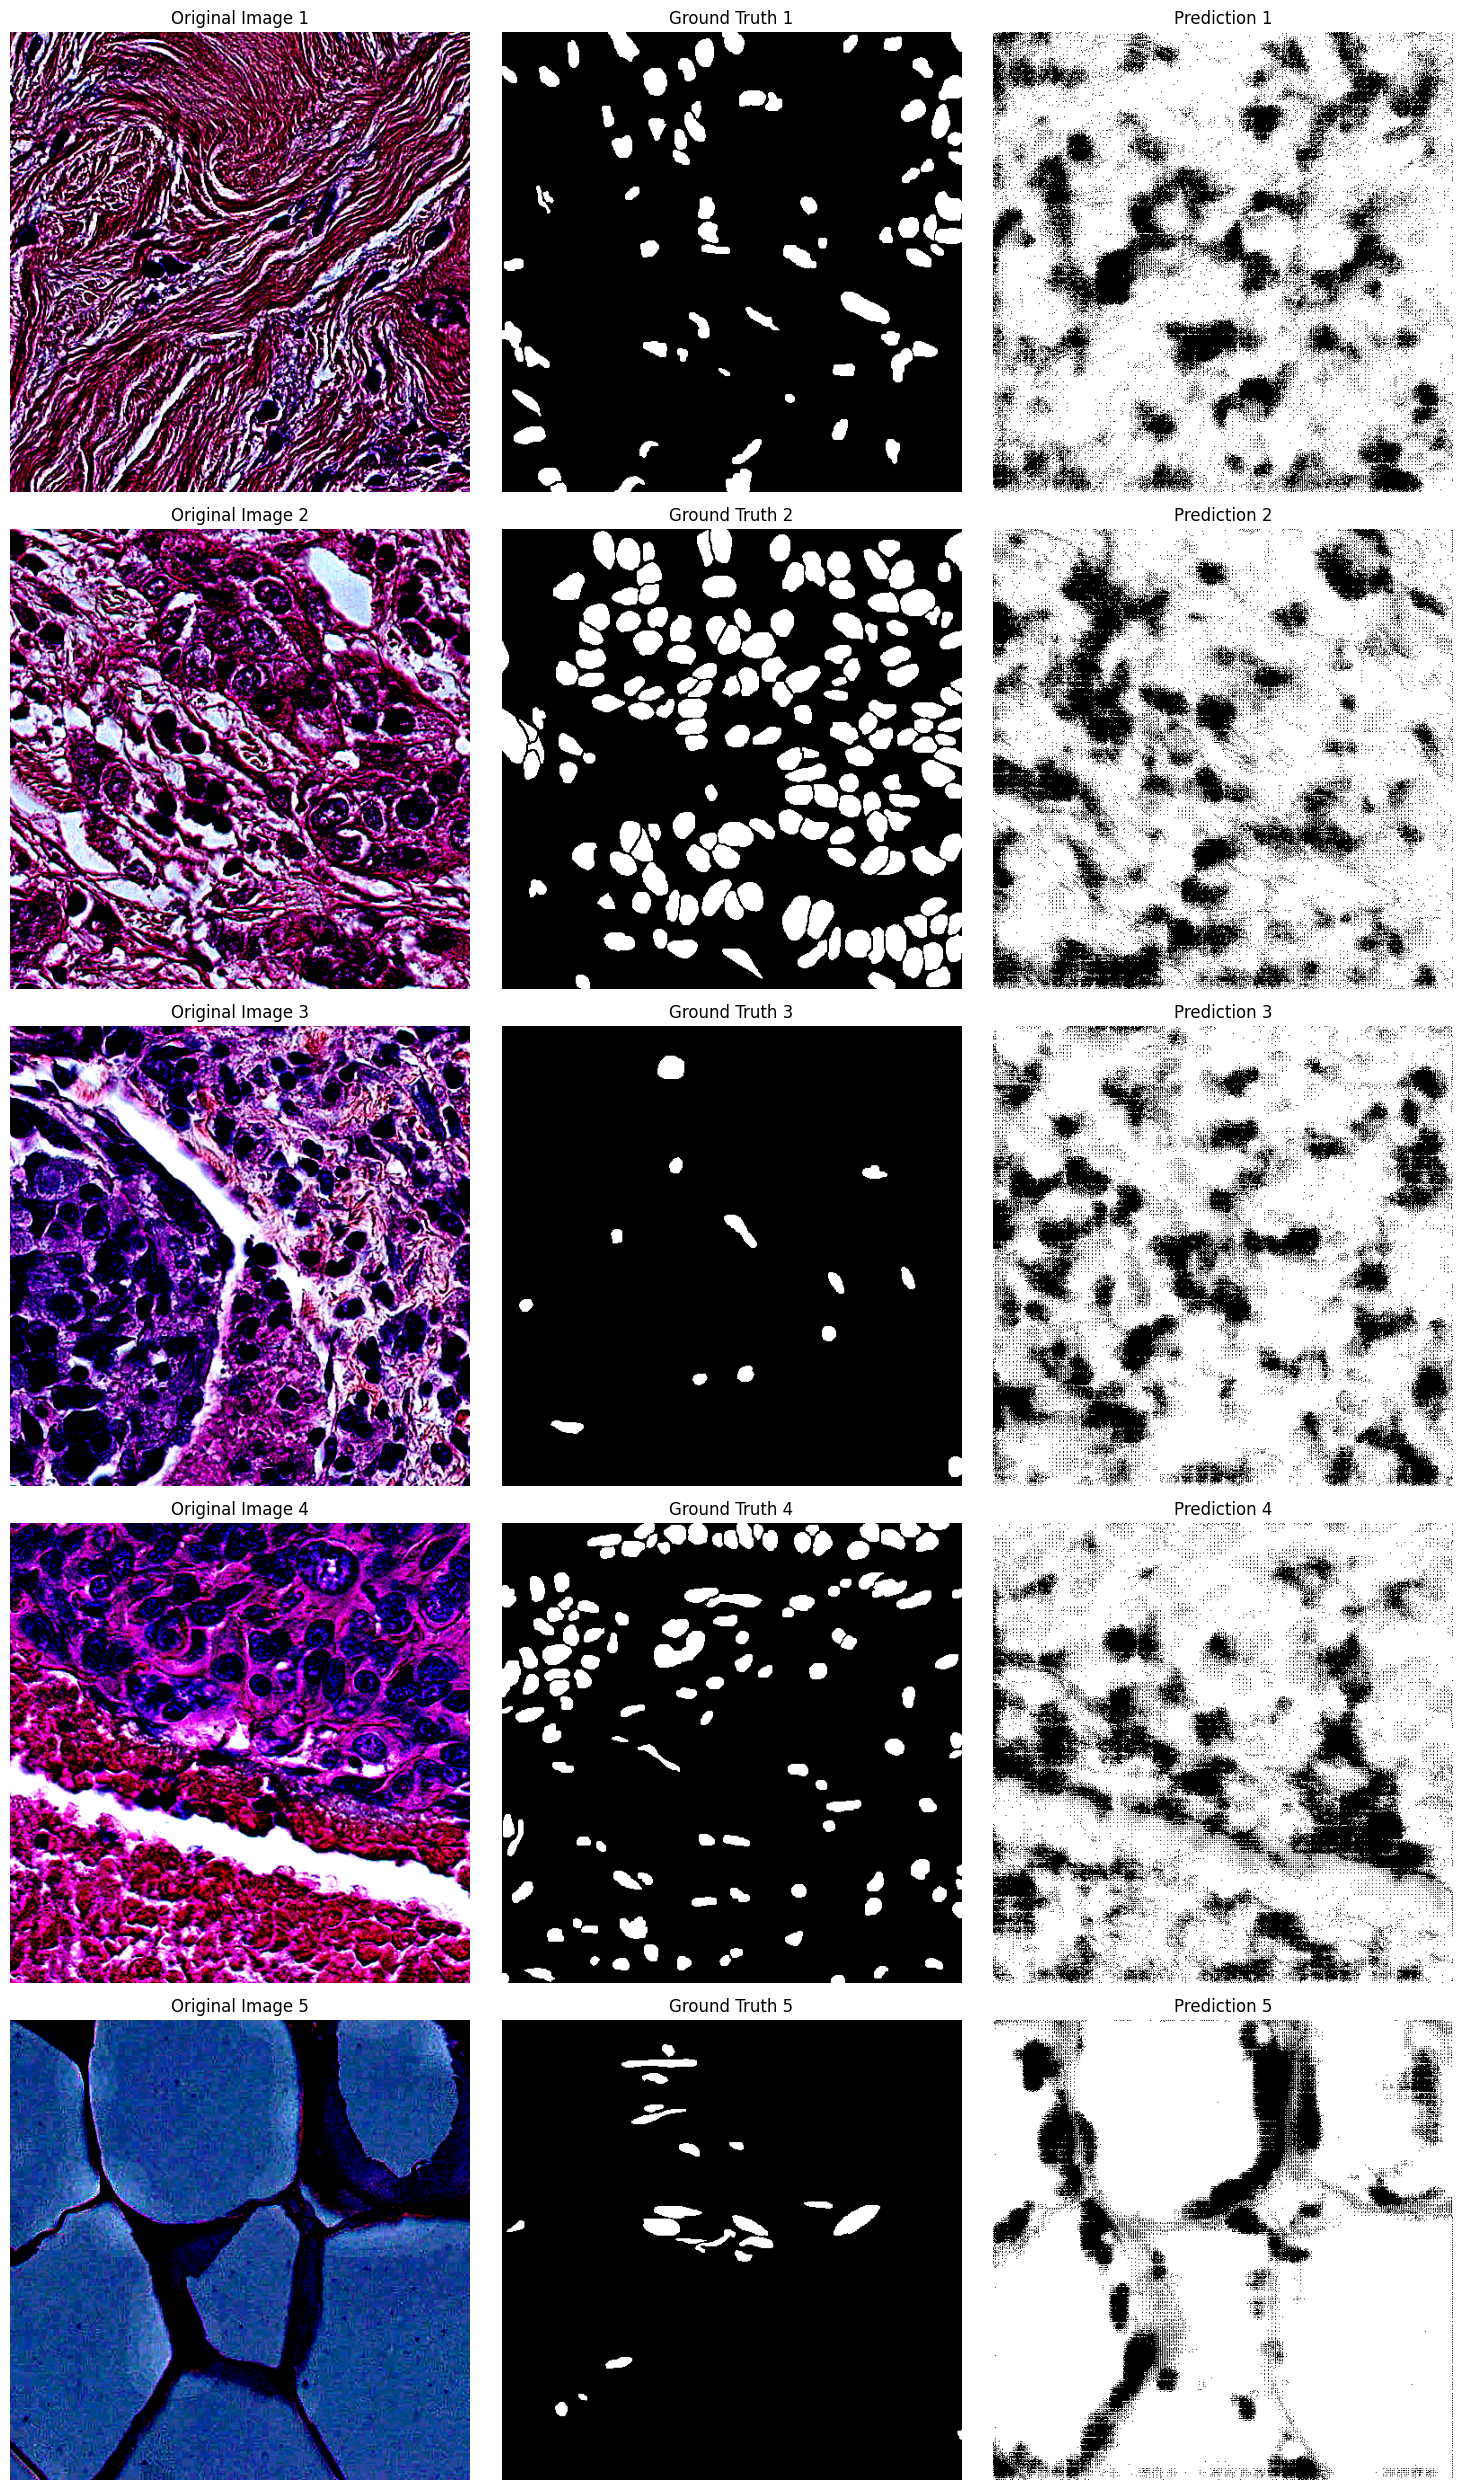

In [23]:
visualize_predictions(model_UNet)

In [24]:
pip install torchmetrics

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install --upgrade torchmetrics


Note: you may need to restart the kernel to use updated packages.


In [26]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, jaccard_score, f1_score

def calculate_metrics(model):
    model.eval()
    dice_scores = []
    iou_scores = []
    f1_scores = []
    
    with torch.no_grad():
        for batch_data in test_loader:
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            
            # Compute predictions
            predictions = model(inputs)
            predictions = torch.sigmoid(predictions)
            
            # Convert to binary masks
            pred_masks = (predictions > 0.5).float()
            true_masks = labels.float()
            
            # Flatten tensors for metric calculation
            pred_masks_np = pred_masks.cpu().numpy().flatten()
            true_masks_np = true_masks.cpu().numpy().flatten()
            
            # Calculate metrics
            # Dice Score (F1 Score)
            dice = f1_score(true_masks_np, pred_masks_np)
            dice_scores.append(dice)
            
            # Jaccard Index (IoU)
            iou = jaccard_score(true_masks_np, pred_masks_np)
            iou_scores.append(iou)
            
            # F1 Score
            f1 = f1_score(true_masks_np, pred_masks_np)
            f1_scores.append(f1)
    
    # Compute mean metrics
    metrics = {
        'Mean Dice Score': np.mean(dice_scores),
        'Mean IoU Score': np.mean(iou_scores),
        'Mean F1 Score': np.mean(f1_scores)
    }
    
    return metrics


In [27]:
model_UNet_metrics = calculate_metrics(model_UNet)
model_dyn_UNet_metrics = calculate_metrics(model_dyn_UNet)

In [28]:

print("UNet Metrics:", model_UNet_metrics)
print("Dyn UNet Metrics:", model_dyn_UNet_metrics)

UNet Metrics: {'Mean Dice Score': 0.22874507978138964, 'Mean IoU Score': 0.13117327330371018, 'Mean F1 Score': 0.22874507978138964}
Dyn UNet Metrics: {'Mean Dice Score': 0.19741816149894126, 'Mean IoU Score': 0.11026646634010479, 'Mean F1 Score': 0.19741816149894126}


# Comparative Analysis

1. Validation Loss:
   - UNet achieved better validation loss **(0.7534 vs 0.7579)**
   - Difference of **0.0045** in favor of UNet

2. Segmentation Metrics:
   - UNet consistently outperformed DynUNet across all metrics
   - Dice Score: UNet better by **3.13** percentage points **(22.87% vs 19.74%)**
   - IoU Score: UNet better by **2.09** percentage points **(13.12% vs 11.03%)**
   - F1 Score: UNet better by **3.13** percentage points **(22.87% vs 19.74%)**

3. Architecture Differences:
   - UNet uses a simpler architecture with consistent strides `(2,2,2,2)`
   - DynUNet uses more complex kernel configurations and varying strides `[[1,1],[2,2],[2,2],[2,2]]`
   - UNet has deeper feature channels `(up to 384)`